<a href="https://colab.research.google.com/github/CeciliaZJ/RoomCraft/blob/main/RoomCraft_App_with_Marketplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import getpass
import hashlib

class UserManager:
    """
    Manages user registration and login.
    Passwords are hashed for security.
    """
    def __init__(self):
        # All users are now students. No roles needed.
        self.users = {}
        print("UserManager initialized.")

    def _hash_password(self, password):
        """Hashes the password using SHA-265."""
        return hashlib.sha256(password.encode()).hexdigest()

    def register(self):
        """Handles the user registration process."""
        print("\n--- Create a New Account ---")
        username = input("Enter a new username: ").lower()

        if username in self.users:
            print("\n This username is already taken. Please try a different one.")
            return

        password = getpass.getpass("Enter a new password: ")
        password_confirm = getpass.getpass("Confirm your password: ")

        if password != password_confirm:
            print("\n Passwords do not match. Please try again.")
            return

        hashed_password = self._hash_password(password)
        self.users[username] = hashed_password
        print(f"\n Success! Account for '{username}' created.")

    def login(self):
        """
        Handles the user login process.
        Returns the username on success, None on failure.
        """
        print("\n--- User Login ---")
        username = input("Enter your username: ").lower()
        password = getpass.getpass("Enter your password: ")

        # Simplified login check without roles
        if self.users.get(username) == self._hash_password(password):
            print(f"\n Welcome back, {username}!")
            return username
        else:
            print("\n Login failed. Incorrect username or password.")
            return None

In [ ]:
import time
import json
import os

class MarketplaceManager:
    """
    Manages item listings and a full messaging/reply system.
    Data is saved to and loaded from a JSON file for persistence.
    """
    def __init__(self, filename="marketplace_data.json"):
        self.filename = filename
        self._load_data()
        print("MarketplaceManager initialized. Data loaded from file.")

    def _load_data(self):
        """Loads data from the JSON file."""
        if os.path.exists(self.filename):
            try:
                with open(self.filename, 'r') as f:
                    data = json.load(f)
                    self.listings = data.get('listings', [])
                    self.conversations = data.get('conversations', [])
                    self.next_item_id = data.get('next_item_id', 1)
            except (json.JSONDecodeError, ValueError):
                self._initialize_empty_data()
        else:
            self._initialize_empty_data()

    def _initialize_empty_data(self):
        """Sets default empty values if no file is found."""
        self.listings = []
        self.conversations = []
        self.next_item_id = 1

    def _save_data(self):
        """Saves the current data to the JSON file."""
        data = {
            'listings': self.listings,
            'conversations': self.conversations,
            'next_item_id': self.next_item_id
        }
        with open(self.filename, 'w') as f:
            json.dump(data, f, indent=4)

    def check_for_new_messages(self, username):
        """Checks if a user has any unread messages."""
        for convo in self.conversations:
            # Check if the user is a participant and the last message is unread and not sent by them
            if username in convo['participants']:
                last_message = convo['messages'][-1]
                if last_message['unread'] and last_message['sender'] != username:
                    return True
        return False

    def create_listing(self, seller_username):
        print("\n--- Create a New Listing ---")
        item_name = input("Item Name: ")
        description = input("Description: ")
        price = input("Price ($): ")
        listing = { "id": self.next_item_id, "seller": seller_username, "name": item_name, "description": description, "price": price }
        self.listings.append(listing)
        self.next_item_id += 1
        self._save_data()
        print(f"\n✅ Success! '{item_name}' has been listed with ID #{listing['id']}.")

    def view_all_listings(self):
        print("\n--- All Marketplace Listings ---")
        if not self.listings: print("No items are currently listed."); return
        for item in self.listings:
            print(f"  ID: {item['id']} | {item['name']} (${item['price']}) | Seller: {item['seller']}")
            print(f"     Description: {item['description']}\n" + "-" * 20)

    def start_or_view_conversation(self, current_user):
        """Starts a new conversation about an item or views an existing one."""
        print("\n--- Send or View Messages ---")
        try: item_id = int(input("Enter the ID of the item you want to discuss: "))
        except ValueError: print("❌ Invalid ID."); return

        target_item = next((item for item in self.listings if item['id'] == item_id), None)
        if not target_item: print("❌ Item with this ID not found."); return

        seller = target_item['seller']
        if seller == current_user: print("❌ You cannot start a conversation about your own item."); return

        # Find existing conversation
        convo = next((c for c in self.conversations if c['item_id'] == item_id and current_user in c['participants']), None)

        if convo:
            print(f"\n--- Conversation about '{target_item['name']}' with {seller} ---")
            for msg in convo['messages']:
                print(f"  {msg['sender']}: {msg['content']}")
        else:
            print(f"Starting new conversation about '{target_item['name']}'...")
            convo = {
                'item_id': item_id,
                'participants': [current_user, seller],
                'messages': []
            }
            self.conversations.append(convo)

        reply = input("Your message (leave blank to cancel): ")
        if reply:
            new_message = {'sender': current_user, 'content': reply, 'unread': True}
            convo['messages'].append(new_message)
            self._save_data()
            print("✅ Message sent!")

    def view_inbox(self, current_user):
        """Shows all conversations for the current user and allows replying."""
        print(f"\n--- Your Inbox ({current_user}) ---")
        user_convos = [c for c in self.conversations if current_user in c['participants']]

        if not user_convos:
            print("You have no messages."); return

        for i, convo in enumerate(user_convos):
            item = next((item for item in self.listings if item['id'] == convo['item_id']), None)
            other_participant = next(p for p in convo['participants'] if p != current_user)
            last_msg = convo['messages'][-1]
            unread_marker = "[!]" if last_msg['unread'] and last_msg['sender'] != current_user else ""

            print(f"{i + 1}. {unread_marker} Conversation with {other_participant} about '{item['name'] if item else 'Deleted Item'}'")

        try:
            choice = int(input("Select a conversation to view/reply (0 to go back): "))
            if choice == 0: return
            selected_convo = user_convos[choice - 1]
        except (ValueError, IndexError):
            print("❌ Invalid selection."); return

        print(f"\n--- Conversation Details ---")
        for msg in selected_convo['messages']:
            print(f"  {msg['sender']}: {msg['content']}")
            # Mark as read if the current user is the recipient
            if msg['sender'] != current_user:
                msg['unread'] = False

        self._save_data() # Save the read status change

        reply = input("Your reply (leave blank to go back): ")
        if reply:
            new_message = {'sender': current_user, 'content': reply, 'unread': True}
            selected_convo['messages'].append(new_message)
            self._save_data()
            print("✅ Reply sent!")

def marketplace_menu(current_user, marketplace_manager, chatbot):
    """The main menu for a logged-in user."""
    while True:
        print(f"\n===== RoomCraft Marketplace (Logged in as {current_user}) =====")
        print("1. List a new item")
        print("2. View all listings")
        print("3. Message about an item")
        print("4. View my Inbox")
        print("5. Generate Room Ideas with AI")
        print("6. Logout")
        choice = input("Please enter your choice: ")

        if choice == '1': marketplace_manager.create_listing(current_user)
        elif choice == '2': marketplace_manager.view_all_listings()
        elif choice == '3': marketplace_manager.start_or_view_conversation(current_user)
        elif choice == '4': marketplace_manager.view_inbox(current_user)
        elif choice == '5': chatbot.run_image_generation()
        elif choice == '6': print(f"Logging out {current_user}..."); return
        else: print("\nInvalid choice.")
        time.sleep(1)



In [ ]:
import os
from PIL import Image
from io import BytesIO
import requests
from IPython.display import display, Markdown
import textwrap
from transformers import pipeline
import torch
import json

# For handling Gemini's specific error types
from google.api_core import exceptions as google_exceptions
# Configure Gemini API KEy
import google.generativeai as google_genai # Added import here
from google import genai # Keep this import for other potential uses of google.genai if needed, but don't configure it
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

google_genai.configure(api_key=GEMINI_API_KEY)
# Removed the incorrect genai.configure call: genai.configure(api_key=GEMINI_API_KEY)

GEMINI_25_MIDEL_NAME = 'gemini-2.5-flash-image-preview'
gemini25_model = google_genai.GenerativeModel(model_name=GEMINI_25_MIDEL_NAME) # Use google_genai here

GEMINI_15_MIDEL_NAME = 'gemini-2.5-flash'
gemini15_model = google_genai.GenerativeModel(model_name=GEMINI_15_MIDEL_NAME) # Use google_genai here

device = "cuda" if torch.cuda.is_available() else "cpu"
text_guardrail = pipeline(
    "text-classification",
    model="Falconsai/offensive_speech_detection",
    device=device
)
print(f"Loaded Text Guardrail (Falconsai/offensive) on {device}.")

# --- Open-Source Image Guardrail (Falconsai)---
image_guardrail = pipeline(
    "image-classification",
    model="Falconsai/nsfw_image_detection",
    device=device
)
print(f"Loaded Image Guardrail (Falconsai/nsfw) on {device}.")

Device set to use cpu


Loaded Text Guardrail (Falconsai/offensive) on cpu.


Device set to use cpu


Loaded Image Guardrail (Falconsai/nsfw) on cpu.


In [ ]:
def pil_to_bytes(image):
    """Converts a PIL.Image to bytes."""
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return buffer.getvalue()

def bytes_to_pil(image_bytes):
    """Converts bytes to a PIL.Image."""
    return Image.open(BytesIO(image_bytes))

def load_image_from_url(url):
    """Loads a PIL.Image from a URL."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error loading image from URL: {e}")
        return None


def check_text_safety_native(prompt_text):
    """Uses a suitable Gemini Flash to evaluate a text prompt."""
    prompt = f"Is the following text safe for a public application? Analyze it for hate speech, harassment, sexually explicit content, or dangerous content. Respond with only 'SAFE' or 'UNSAFE'. \n\nText: \"{prompt_text}\""
    try:
        response = gemini15_model.generate_content([prompt_text])
        # print(response)
        result_text = ""
        if response.candidates and response.candidates[0].content.parts:
            result_text = response.candidates[0].content.parts[0].text
        is_unsafe = "UNSAFE" in result_text.strip().upper()
        return {"is_unsafe": is_unsafe, "reason": result_text}
    except Exception as e:
        return {"is_unsafe": True, "reason": f"Native check error: {e}"}

# LAYER 1: Native Gemini Check
def check_text_safety_native_25(prompt_text):
    """Uses Gemini 2.5 Flash to evaluate a text prompt."""
    prompt = f"Is the following text safe for a public application? Analyze it for hate speech, harassment, sexually explicit content, or dangerous content. Respond with only 'SAFE' or 'UNSAFE'. \n\nText: \"{prompt_text}\""
    try:
        response = gemini25_model.generate_content([prompt_text])
        # print(response)
        result_text = ""
        if response.candidates and response.candidates[0].content.parts:
            result_text = response.candidates[0].content.parts[0].text
        is_unsafe = "UNSAFE" in result_text.strip().upper()
        return {"is_unsafe": is_unsafe, "reason": result_text}
    except Exception as e:
        return {"is_unsafe": True, "reason": f"Native check error: {e}"}


# LAYER 2: Open-Source Check
def check_text_safety_open(prompt_text):
    """Uses the Falconsai model to evaluate a text prompt."""
    results = text_guardrail(prompt_text)
    result = results[0]
    is_unsafe = result['label'].lower() == 'offensive'
    print(results)
    return {"is_unsafe": is_unsafe, "score": result['score'], "category": result['label']}



# LAYER 1: Native Gemini Check

def check_image_safety_native(pil_image):
    """Uses a suitable Gemini Flash to evaluate an image."""
    try:
        if gemini15_model is None:
            return {"is_unsafe": True, "reason": "Native check error: gemini15_model is None"}

        prompt = "Is this image safe for a public application? Analyze it for nudity, violence, or gore. Respond with only 'SAFE' or 'UNSAFE'."
        # Gemini 1.5 Flash can take a PIL.Image object directly
        # print("Calling gemini15_model.generate_content...")
        response = gemini15_model.generate_content([prompt, pil_image])
        # print("Received response from gemini15_model.generate_content:")
        # print(response) # Print the raw response object for debugging

        result_text = ""
        if response and response.candidates and response.candidates[0].content.parts:
            result_text = response.candidates[0].content.parts[0].text
            # print(f"Extracted result_text: {result_text}")

        is_unsafe = "UNSAFE" in result_text.strip().upper()

        return {"is_unsafe": is_unsafe, "reason": result_text.strip()}
    except Exception as e:
        print(f"Native check error caught in exception block: {e}")
        return {"is_unsafe": True, "reason": f"Native check error: {e}"}

# LAYER 2: Open-Source Check
def check_image_safety_open(pil_image):
    """Uses the Falconsai model to evaluate an image."""
    results = image_guardrail(pil_image)
    nsfw_score = next((item['score'] for item in results if item['label'] == 'nsfw'), 0)
    is_unsafe = nsfw_score > 0.7 # 70% threshold
    return {"is_unsafe": is_unsafe, "nsfw_score": nsfw_score}

#  Define the Autorater Function

def run_autorater(generated_image, original_prompt):
    """Uses a suitable Gemini Flash to rate the generated image based on criteria."""
    display(Markdown("--- \n#### 🤖 Autorater Running..."))

    criteria = f"""
    Please act as a quality autorater. Evaluate the following image based on its adherence to the original prompt.

    Original Prompt: "{original_prompt}"

    Evaluate on a scale of 1-5 for the following criteria:
    1.  **Prompt Adherence:** How well does the image match the prompt? (1=Poor, 5=Perfect)
    2.  **Aesthetics:** Is the image high-quality and visually appealing? (1=Ugly, 5=Beautiful)
    3.  **Creativity:** Is the image creative and interesting? (1=Boring, 5=Highly Creative)

    Please provide your rating in a JSON format.
    """

    try:
        response = gemini15_model.generate_content(
         [criteria, generated_image]
        )
        display(Markdown(response.text))
    except Exception as e:
        display(Markdown(f"Autorater failed: {e}"))


In [ ]:
# @title Native Nano Banana Generation

def generate_image(prompt, image):
  response = gemini25_model.generate_content(
      contents=[prompt, image],
  )

  for part in response.candidates[0].content.parts:
      if part.text is not None:
          print(part.text)
      elif part.inline_data is not None:
          generated_image = Image.open(BytesIO(part.inline_data.data))
          generated_image.save("generated_image.png")
          display(generated_image)
  return response

In [ ]:
class Chatbot:
    def chatbot(self): # Added self
        print("Welcome to the RoomCraft Idea Chatbot!")
        # The main logic for image loading and prompt getting will be in run_image_generation for better flow

    def prompt(self): # Added self
        user_input = input("Type your prompt: ")
        return user_input

    def run_image_generation(self): # Added self
        print("\n--- Generate Room Ideas with AI ---")
        print("Upload your pic.")
        room_input = input("Type your image path: ")
        try:
            room_image = Image.open(room_input)
            room_image.save("room_image.png")
            print(f"Loaded {room_input}")

            # Ask for the prompt BEFORE displaying the image
            prompt_text = self.prompt() # Call prompt as a method

            if prompt_text:
                display(room_image) # Display the image after getting the prompt
                # Assuming generate_image is a global function or imported
                response = generate_image(prompt_text, room_image) # Capture the response
                self.display_generated_image_from_response(response) # Call the display method
            else:
                print("Prompt cannot be empty.")

        except FileNotFoundError:
            print(f"Error: Image file not found at {room_input}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def display_generated_image_from_response(self, response):
        """
        Extracts and displays the image from a Gemini API response object.

        Args:
            response: The response object from the Gemini API's generate_content call.
        """
        try:
            for candidate in response.candidates:
                for part in candidate.content.parts:
                    if part.inline_data and part.inline_data.data:
                        image_bytes = part.inline_data.data
                        image = Image.open(BytesIO(image_bytes))
                        display(image)
                        print("Image displayed successfully.")
                        return image # Assuming only one image per response for simplicity
            print("No image data found in the response.")
        except Exception as e:
            print(f"Error displaying image: {e}")

UserManager initialized.
MarketplaceManager initialized. Data loaded from file.

===== Welcome to RoomCraft (Logged Out) =====
1. Register a new account
2. Login
3. Exit
Please enter your choice: 2

--- User Login ---
Enter your username: khinesu
Enter your password: ··········

 Login failed. Incorrect username or password.

===== Welcome to RoomCraft (Logged Out) =====
1. Register a new account
2. Login
3. Exit
Please enter your choice: 2

--- User Login ---
Enter your username: khinesu
Enter your password: ··········

 Login failed. Incorrect username or password.

===== Welcome to RoomCraft (Logged Out) =====
1. Register a new account
2. Login
3. Exit
Please enter your choice: 1

--- Create a New Account ---
Enter a new username: khinesu
Enter a new password: ··········
Confirm your password: ··········

 Success! Account for 'khinesu' created.

===== Welcome to RoomCraft (Logged Out) =====
1. Register a new account
2. Login
3. Exit
Please enter your choice: 

Invalid choice.

====

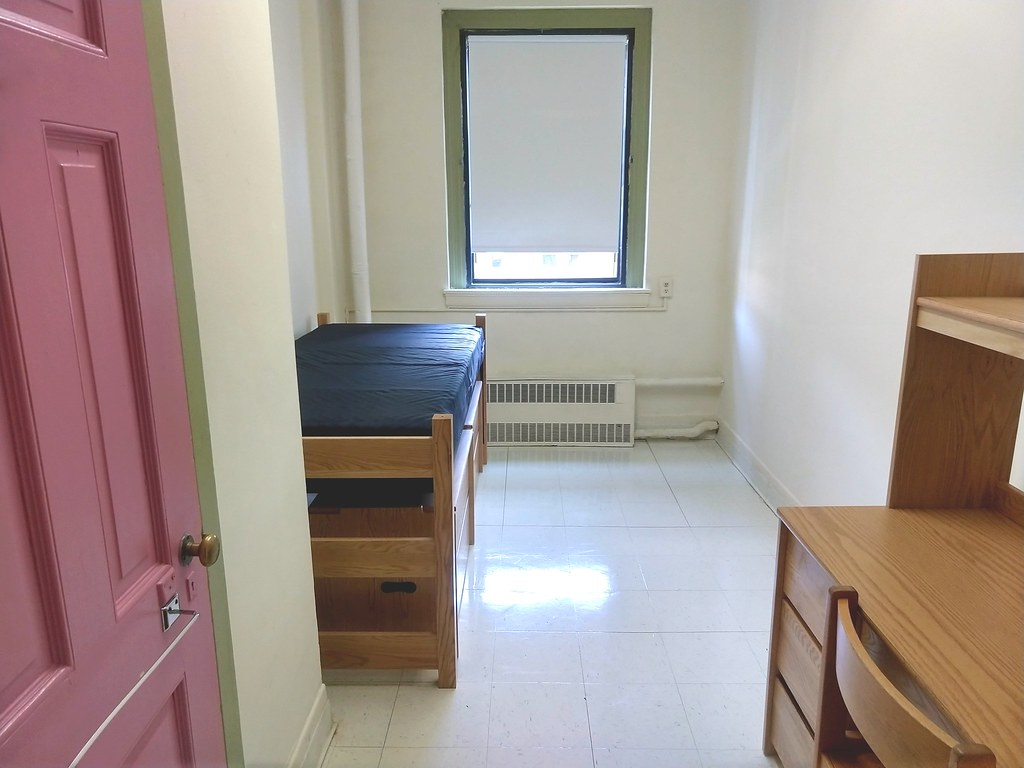

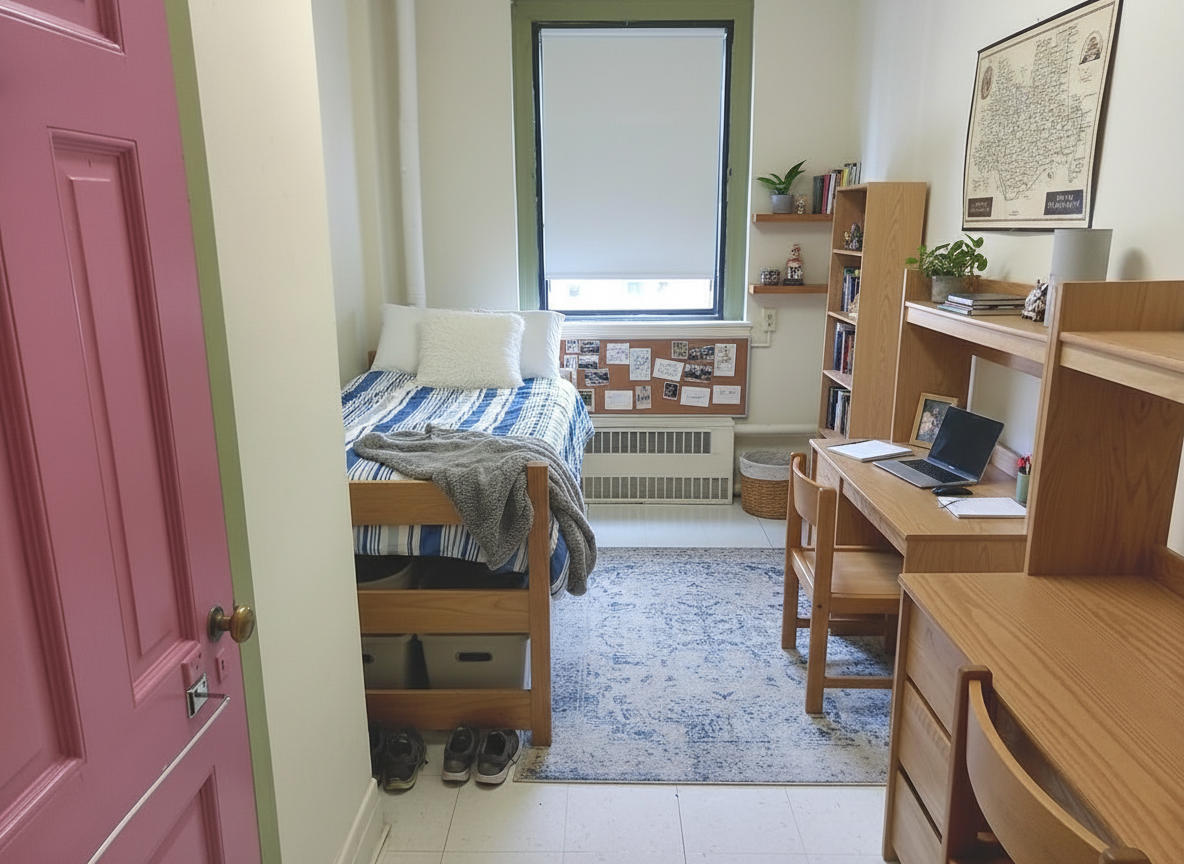

Image displayed successfully.

===== RoomCraft Marketplace (Logged in as khinesu) =====
1. List a new item
2. View all listings
3. Message about an item
4. View my Inbox
5. Generate Room Ideas with AI
6. Logout
Please enter your choice: 6
Logging out khinesu...

--- You have been logged out and returned to the main menu. ---

===== Welcome to RoomCraft (Logged Out) =====
1. Register a new account
2. Login
3. Exit
Please enter your choice: 3
Exiting the program. Goodbye!


In [ ]:
import time
# from user_manager import UserManager
# from marketplace import MarketplaceManager, marketplace_menu
# from chatbot import Chatbot

def main_loop():
    """
    The main entry point for the application.
    Initializes all managers and the chatbot.
    """
    user_manager = UserManager()
    marketplace_manager = MarketplaceManager()
    chatbot = Chatbot()

    while True:
        print("\n===== Welcome to RoomCraft (Logged Out) =====")
        print("1. Register a new account")
        print("2. Login")
        print("3. Exit")
        choice = input("Please enter your choice: ")

        if choice == '1':
            user_manager.register()
        elif choice == '2':
            current_user = user_manager.login()
            if current_user:
                # --- NEW FEATURE: NOTIFICATION CHECK ---
                if marketplace_manager.check_for_new_messages(current_user):
                    print("\n[!] You have new messages in your inbox!")
                # ----------------------------------------

                print("\n--- Entering Marketplace ---")
                marketplace_menu(current_user, marketplace_manager, chatbot)
                print("\n--- You have been logged out and returned to the main menu. ---")
        elif choice == '3':
            print("Exiting the program. Goodbye!")
            break
        else:
            print("\nInvalid choice.")

        time.sleep(1.5)

if __name__ == "__main__":
    main_loop()

